In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.fft as fft
import seaborn as sns
sns.set()

from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import sys
sys.path.append("/home/evangelos/workspace/Channel_Charting/")
from tools import utils
from src.models import supervised_classifier, supervised_regressor
from src.utils.data_preparation import SupervisedDataset

def preprocessing(data, first_data, rx_positions=None, padding=True, reduce=False, keep_idces=None):
    data = data[keep_idces]
    if rx_positions:
        data = utils.drop_top_right(data, rx_positions)
    data = utils.standarize(data)
    data = utils.fillna(data)
    if padding:
        data = utils.zero_padding_as(data, first_data)
    #data = utils.take_norm(data)
    if reduce:
        data = reduce_to_mean_std(data)
    
    return data

def reduce_to_mean_std(x):
    return np.stack([np.mean(x,axis=1), 
                          np.std(x,axis=1)], axis=1)

def get_k_best(predictions, K):
    """Function that return the indices of most K most confident predictions"""
    K_preds = sorted(list(enumerate(predictions.max(dim=1).values.detach())), key=lambda x: x[1], reverse=True)[:K]
    return [x[0] for x in K_preds]

def get_k_worst(predictions, K):
    """Function that return the indices of most K most confident predictions"""
    K_preds = sorted(list(enumerate(predictions.max(dim=1).values.detach())), key=lambda x: x[1], reverse=False)[:K]
    return [x[0] for x in K_preds]

# Introduction

In this notebook I explore the possibility of training a classifier model for Channel Charting using semi-supervised learning. I use the same preprocessing as in the supervised setting. The idea is to see if with a small number of labeled samples we are able to generate predictions of comparable accuracy to the supervised method.

In [129]:
# configuration
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
batch_size = 64
train_size = 2500
n_clusters = 3
K_best = 250
drop_top_right = False
custom_labels = True

In [130]:
# load datasets
(raw_taps, raw_phi, raw_theta, raw_rx_positions, raw_tx_positions) = utils.load_datasets()

In [131]:
#fourier transform and undersample taps
raw_freq_taps = fft.fft(raw_taps , workers=-1)[:,:,::2]

In [132]:
#get indices for tap outliers
mean_freq = np.mean(raw_freq_taps, axis=(1,2))
mu = np.mean(mean_freq)
std = np.std(mean_freq)
idces = ~(np.abs(mean_freq-mu) >2*std)

if drop_top_right:
    pos = raw_rx_positions
else:
    pos = None

In [133]:
taps = preprocessing(raw_freq_taps, raw_freq_taps,rx_positions=pos , keep_idces=idces)
taps = np.hstack([np.real(taps), np.imag(taps)])

In [134]:
phi = preprocessing(raw_phi, taps, rx_positions=pos , keep_idces=idces)

In [135]:
theta = preprocessing(raw_theta, taps, rx_positions=pos , keep_idces=idces)

In [136]:
y  = preprocessing(raw_rx_positions, taps, rx_positions=pos , keep_idces=idces, padding=False)[:,:2]

In [137]:
X = np.hstack([taps, phi[:-10], theta[:-10]])
X.shape

(23687, 84, 50)

In [138]:
#assign labels to certain areas of the map using kmeans
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, MiniBatchKMeans
km = MiniBatchKMeans(n_clusters=n_clusters) 
km = km.fit(y)
labels = km.predict(y)

In [139]:
def in_alley(x,y):
    f1 = lambda x: 3.2*x - 3.8
    f2 = lambda x: 3.2*x - 5.8
    x_min = x_2.min()
    x_max = x_2.max()+0.62
    if (x>=x_min and x<x_max):
        if (f1(x)>=y and f2(x)<=y):
            return True
    return False

In [140]:
if custom_labels:
    alley_list = [in_alley(y_[0], y_[1]) for y_ in y]
    labels[alley_list] = n_clusters


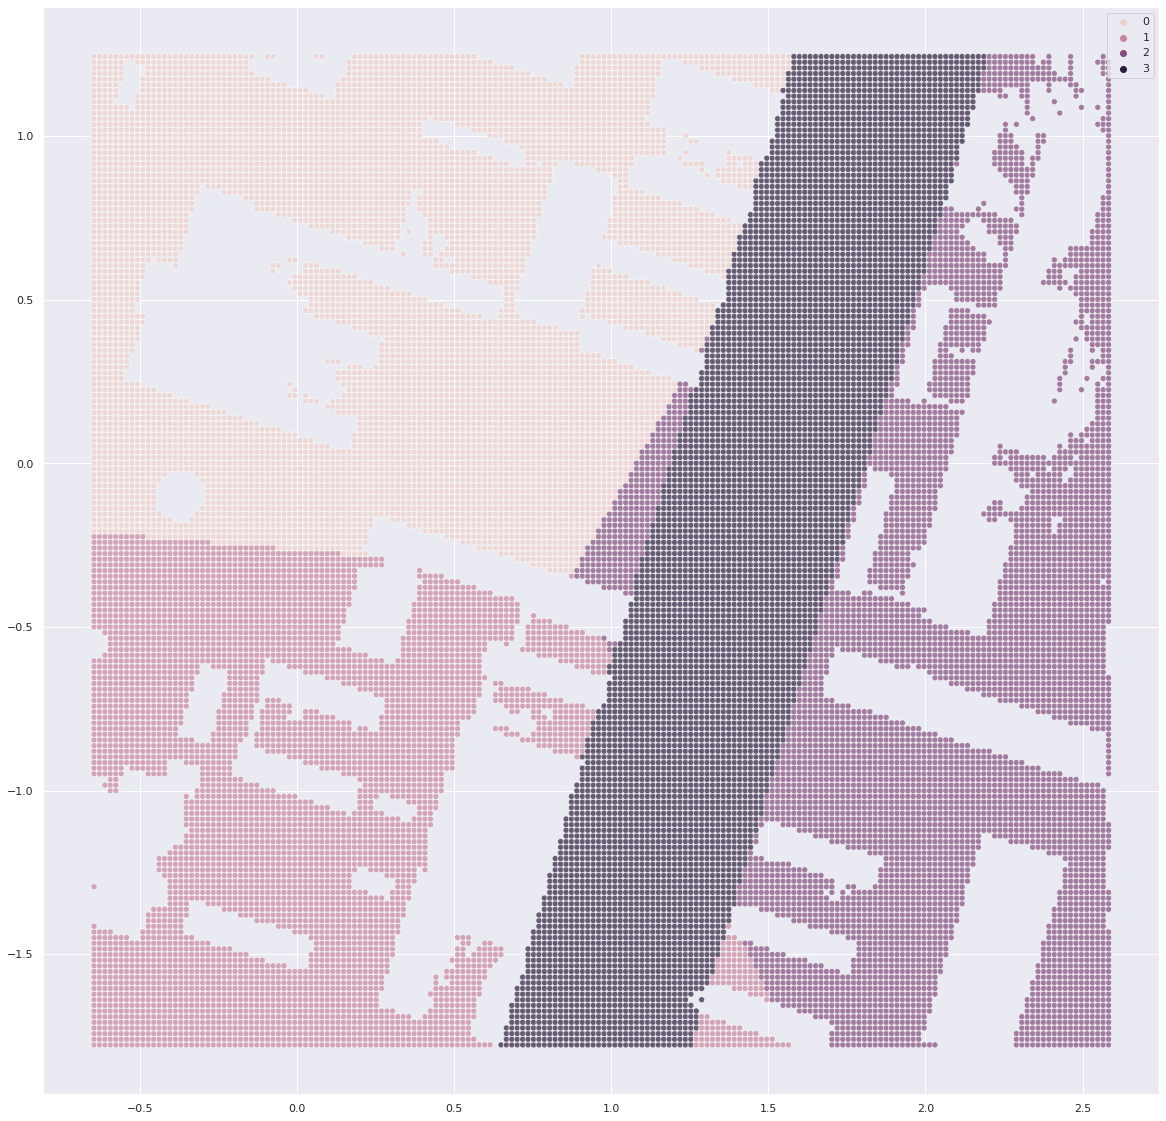

In [141]:
plt.figure(figsize=(20,20))
sns.scatterplot(y[:,0], y[:,1], hue=labels, alpha=0.7)

# Semi Supervised Learning

We implement semi-supervised training as:
1. Train the model with the initial labelled subset.
2. Perform predictions on the unlabelled subset
3. Take the K most confident prediction and include them as labels, and their samples in the train dataset.
4. Repeat untill we have used the whole dataset

In [121]:
#train test split
# keep 25% of the dataset for testing
train_X, test_X ,train_y, test_y, train_labels, test_labels = train_test_split(X, y, labels)
test_DS = SupervisedDataset(test_X, test_labels)
test_loader = DataLoader(test_DS, batch_size=batch_size)

# use 2500 ~ 10% of the original dataset as labeled dataset
(X_sampled, X_remaining, 
 _, _, 
 labels_sampled, labels_remaining) = train_test_split(train_X, 
                                                      train_y, 
                                                      train_labels, 
                                                      train_size=train_size)
its = 0
while len(X_remaining)>train_size:
    
    train_DS = SupervisedDataset(X_sampled, labels_sampled)
    train_loader = DataLoader(train_DS, batch_size=batch_size, shuffle=True)

    
    if its == 0:
        model = supervised_classifier.Classifier(channels=train_DS.channels(), nb_labels=n_clusters)
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters())
    best_val_loss = 9999
    count=0
    
    for epoch in range(50):
        loss, acc = supervised_classifier.train(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = supervised_classifier.test(model, test_loader, criterion, device)
        print(f"Epoch: {epoch}, Training Loss: {loss:.3f}, Training Accuracy: {acc:.3f} ,Validation Loss: {val_loss:.2f}, Validation Accuracy: {val_acc:.3f}")


        if best_val_loss < val_loss:
            count += 1
        else:
            best_val_loss = val_loss
        if count > 3:
            break
            
    # add confident samples to training
    # generate predictions for the remaining dataset
    yhats = model(torch.Tensor(X_remaining))
    #get indices for the most confident predictions
    idces = get_k_best(yhats, K_best)
    # take the samples corresponding to those predictions and add them to the dataset
    (confident_X, 
     confident_labels) = (X_remaining[idces],
                     # get the labels of the most confident predictions
                     yhats[idces].argmax(dim=1).detach().numpy())
    # concatenate the old and the new samples
    X_sampled = np.concatenate([X_sampled, confident_X])
    #y_sampled = np.concatenate([y_sampled, confident_y])
    labels_sampled = np.concatenate([labels_sampled, confident_labels])
    
    mask_array = np.zeros(len(X_remaining), dtype=bool)
    mask_array[idces] = True
    # remove the added samples from the remaining
    X_remaining, labels_remaining = (X_remaining[~mask_array], 
                                                  labels_remaining[~mask_array])
    
    print(len(X_remaining))
    its += 1
    if its==10:
        break

Epoch: 0, Training Loss: 1.100, Training Accuracy: 0.420 ,Validation Loss: 1.04, Validation Accuracy: 0.470
Epoch: 1, Training Loss: 0.972, Training Accuracy: 0.550 ,Validation Loss: 0.89, Validation Accuracy: 0.586
Epoch: 2, Training Loss: 0.846, Training Accuracy: 0.636 ,Validation Loss: 0.82, Validation Accuracy: 0.637
Epoch: 3, Training Loss: 0.776, Training Accuracy: 0.684 ,Validation Loss: 0.79, Validation Accuracy: 0.671
Epoch: 4, Training Loss: 0.756, Training Accuracy: 0.698 ,Validation Loss: 0.76, Validation Accuracy: 0.677
Epoch: 5, Training Loss: 0.761, Training Accuracy: 0.689 ,Validation Loss: 0.81, Validation Accuracy: 0.656
Epoch: 6, Training Loss: 0.732, Training Accuracy: 0.698 ,Validation Loss: 0.74, Validation Accuracy: 0.682
Epoch: 7, Training Loss: 0.692, Training Accuracy: 0.723 ,Validation Loss: 0.67, Validation Accuracy: 0.713
Epoch: 8, Training Loss: 0.636, Training Accuracy: 0.751 ,Validation Loss: 0.69, Validation Accuracy: 0.726
Epoch: 9, Training Loss: 0.6

In [122]:
yhats = model(test_DS[:][0]).detach().argmax(dim=1)

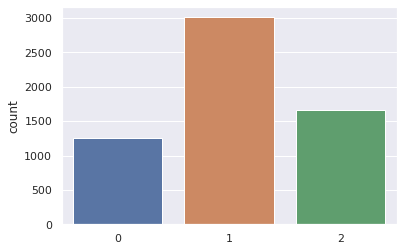

In [123]:
sns.countplot(yhats.detach().numpy())

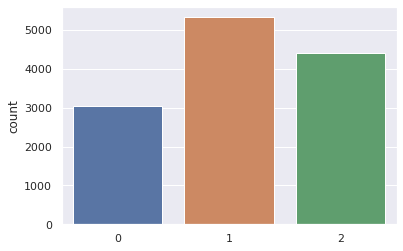

In [124]:
sns.countplot(labels_remaining)

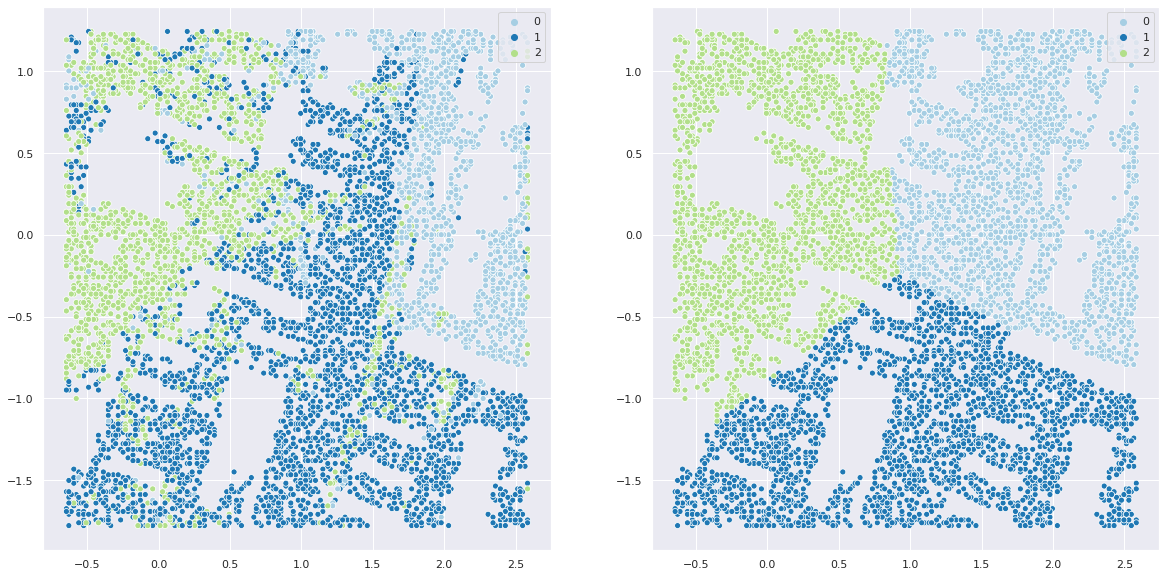

In [125]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
sns.scatterplot(test_y[:,0], test_y[:,1], hue=yhats, legend="full", palette='Paired')
plt.subplot(1,2,2)
sns.scatterplot(test_y[:,0], test_y[:,1], hue=test_labels, legend="full", palette='Paired')
plt.show()

We can see that our neural network has trouble distinguishing clusters along the "road" around the middle of the map. Maybe testing another set of cluster, utilizing some domain knowledge would make sense.

In [126]:
print(classification_report(yhats, test_labels))

              precision    recall  f1-score   support

           0       0.58      0.88      0.70      1249
           1       0.89      0.64      0.75      3010
           2       0.73      0.81      0.76      1663

    accuracy                           0.74      5922
   macro avg       0.73      0.78      0.74      5922
weighted avg       0.78      0.74      0.74      5922



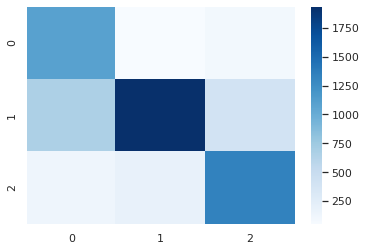

In [127]:
sns.heatmap(confusion_matrix(yhats, test_labels), cmap='Blues')
plt.show()